# Studying the Growth Factor

Reference: [Growth of Cosmic Structure: Probing Dark Energy Beyond Expansion](https://arxiv.org/pdf/1309.5385)

The equations governing the matter perturbations (in the Newtonian gauge) in a CDM-dominated universe are:

\begin{align}
    \delta' &= -kv - 3\Phi' \\
    v' &= -\mathcal{H}v + k\Psi \\
    k^2 \Phi &= 4\pi G a^2 \rho \left( \delta + \frac{3\mathcal{H}v}{k} \right) \\
    k^2 (\Phi + \Psi) &= 0
\end{align}

Furthermore, we can assume that
\begin{equation}
    \rho = \rho_\mathrm{cr}\Omega_m a^{-3} = \frac{3H_0^2}{8\pi G}\Omega_m a^{-3}
\end{equation}

We can use the metric equations to write the metric variables in terms of the matter perturbations variables. In particular, we know that $\Psi = - \Phi$. After lengthy calculations, we can write

\begin{equation}
    \Phi' = -\frac{\mathcal{H}C}{k^2 + 3C}\left( 1 + \frac{3C}{k^2} \right)\delta - \frac{kC}{k^2 + 3C}\left[ 1 + 3\frac{\mathcal{H}^2}{k^2} - 3\frac{\mathcal{H}' - \mathcal{H}^2}{k^2} + 9\frac{\mathcal{H^2}C}{k^4} \right]v,
\end{equation}
where
\begin{equation}
    C = \frac{3H_0^2\Omega_m}{2a}.
\end{equation}
Furthermore, we have the Friedmann equations,
\begin{align}
    \mathcal{H}^2 &= \frac{8\pi G a^2 \rho}{3}, \\
    \frac{a''}{a} = \mathcal{H}' - \mathcal{H}^2 &= -\frac{4\pi G a^2}{3}(\rho + 3P).
\end{align}

I will use units where $c$ = $8\pi G$ = $H_0$ = 1

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint, quad
from scipy.optimize import root_scalar

In [46]:
# Constants
H0 = 1
rho_cr = 3

# Free and derived parameters
Omega_m = 0.3
Omega_r = 2.5e-5
Omega_Lambda = 1 - Omega_m - Omega_r
a_eq = Omega_r/Omega_m
w_r = 1/3
w_m = 0
w_Lambda = -1

def rho(a):
    return rho_cr*(Omega_r*a**-4 + Omega_m*a**-3 + Omega_Lambda)

def P(a):
    return rho_cr*(w_r*Omega_r*a**-4 + w_m*Omega_m*a**-3 + w_Lambda*Omega_Lambda)

def H_curly(a):
    return a*np.sqrt(rho(a)/3)

def scale_factor_horizon_entry(k):
    # Find the value of a such that k = H_curly
    return root_scalar(lambda a: H_curly(a) - k, x0=1e-4).root

# Defining scale factor grid for integration
a_ini = 1e-7
a_switch = 1e-4
loga_int = np.linspace(np.log(a_ini), np.log(a_switch), 500)
a_int_lin = np.linspace(a_switch, 1, 500)
a = np.concatenate([np.exp(loga_int), a_int_lin])

# Derivative of the system with respect to scale factor
def dy_da(y, a, k=0.1):
    delta, v = y
    H = H_curly(a)
    rho_now = rho(a)
    P_now = P(a)
    kPhi = 0.5*a**2*rho_now*(delta + 3*H*v/k)/k
    C = 3*Omega_m/(2*a)
    H_prime_minus_H2 = -(1/6)*a**2*(rho_now + 3*P_now)
    Phi_prime = - H*C*(1 + 3*C/H**2)*delta \
                - k*C*(1 + 3*H**2/k**2 - 3*H_prime_minus_H2/k**2 + 9*H**2*C/k**4)*v
    Phi_prime /= k**2 + 3*C
    delta_prime = -k*v - 3*Phi_prime
    v_prime = -H*v - kPhi
    return [delta_prime/(a*H), v_prime/(a*H)]

def dy_dloga(y, loga, k=0.1):
    a = np.exp(loga)
    deriv = dy_da(y, a, k)
    return list(map(lambda x: a*x, deriv))

def integrate(k):
    # Initial conditions
    # y = (\delta_m, v)
    As = 2.1e-9
    ns = 1.0
    k_p = 1
    Delta_k = As*(k/k_p)**(ns - 1)
    P_k = 2*np.pi**2*Delta_k/k**3
    delta_ini = np.sqrt(P_k)
    # delta_ini = 1e-6
    y0 = [delta_ini, 0.0]
    partial = odeint(dy_dloga, y0, t=loga_int, args=(k,))
    y_switch = partial[-1]
    partial2 = odeint(dy_da, y_switch, t=a_int_lin, args=(k,))
    return np.concatenate([partial, partial2])

ks = [1e-5, 1e-3, 1e-2,]
results = [integrate(k) for k in ks]

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 = -0.1611809565096D+02   r2 =  0.2526471596559D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 = -0.1611809565096D+02   r2 =  0.3814945451834D-22
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 = -0.1611809565096D+02   r2 =  0.7629890903667D-22
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 = -0.1611809565096D+02   r2 =  0.7629890903667D-22
 lsoda--  warning..internal t (=r1) 

/tmp/ipykernel_15196/1311331914.py:68: ODEintWarning: Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.
  partial2 = odeint(dy_da, y_switch, t=a_int_lin, args=(k,))


ue anyway  
      in above,  r1 = -0.1611809565096D+02   r2 =  0.8100922088324D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 = -0.1611809565096D+02   r2 =  0.8100922088324D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 = -0.1611809565096D+02   r2 =  0.8100922088324D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 = -0.1611809565096D+02   r2 =  0.8100922088324D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 = -0

/tmp/ipykernel_15196/1311331914.py:21: RuntimeWarning: invalid value encountered in sqrt
  return a*np.sqrt(rho(a)/3)
/tmp/ipykernel_15196/1380256366.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


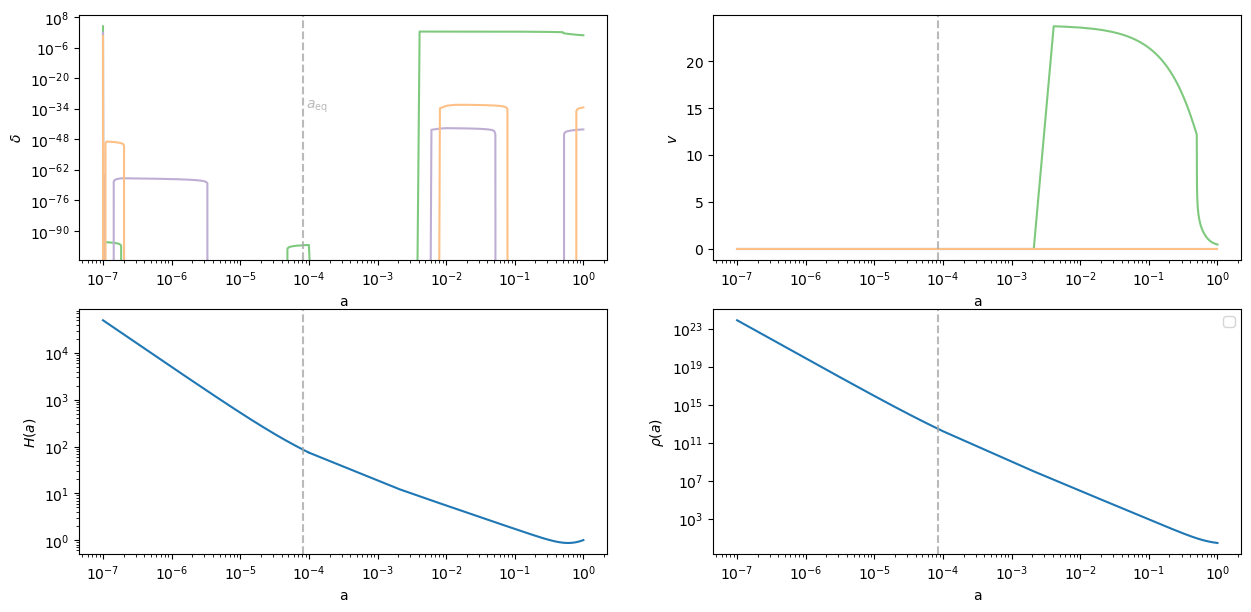

In [47]:
# From https://colorbrewer2.org/#type=qualitative&scheme=Accent&n=6
colors = [
    "#7fc97f",
    "#beaed4",
    "#fdc086",
    "#ffff99",
    "#386cb0",
    "#f0027f"
]

fig, axs = plt.subplots(2, 2, figsize=(15,7))
for k, result, color in zip(ks, results, colors):
    delta, v = result.T
    rho_a = rho(a)
    H_a = H_curly(a)
    Phi = 0.5*a**2*rho_a*(delta + 3*H_a*v/k)/k**2
    a_horizon_entry = scale_factor_horizon_entry(k)
    axs[0, 0].loglog(a, delta, label=f"k = {k}", color=color)
    axs[0, 1].semilogx(a, v, label=f"k = {k}", color=color)
    for ax in axs[0]: ax.axvline(a_horizon_entry, alpha=0.9, ls="--", color=color)

axs[1, 0].loglog(a, H_a)
axs[1, 1].loglog(a, rho_a)

for ax in axs.flatten():
    ax.axvline(a_eq, c="darkgray", alpha=0.8, ls="--")
    ax.set_xlabel("a")

axs[0, 0].text(a_eq*1.1, delta[-1]*0.95, r"$a_\mathrm{eq}$", c="darkgray", alpha=0.8)
axs[0, 0].set_ylabel(r"$\delta$")
axs[0, 1].set_ylabel(r"$v$")
axs[1, 0].set_ylabel(r"$H(a)$")
axs[1, 1].set_ylabel(r"$\rho(a)$")
plt.legend()
plt.savefig("deltas.pdf")

2.0999250000000007

In [41]:
for k, result, color in zip(ks, results, colors):
    delta, v = result.T
    print(delta)

[1.00000000e-006 1.00000000e-006 3.78576699e-270 ... 1.00000000e+000
 1.00000000e+000 1.00000000e+000]
[1.00000000e-006 1.00000000e-006 3.78576699e-270 ... 1.00000000e+000
 1.00000000e+000 1.00000000e+000]
[1.00000000e-006 1.00000000e-006 3.78576699e-270 ... 1.00008064e+000
 1.00008064e+000 1.00008065e+000]
